In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import datetime
import time
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score,KFold

In [76]:
#Loading data
PATH = "/root/competitive-data-science-predict-future-sales/"

item_category = pd.read_csv(PATH+'item_categories.csv')
train = pd.read_csv(PATH+'sales_train.csv')
sample = pd.read_csv(PATH+"sample_submission.csv")
shops = pd.read_csv(PATH+"shops.csv")
test = pd.read_csv(PATH+"test.csv")
items = pd.read_csv(PATH+"items.csv")

In [ ]:
#Data Merging
train_df = train.merge(test,on=['item_id','shop_id',],how='left')
train_df = train_df.merge(items[['item_id','item_category_id']],on='item_id',how='left')
train_df = train_df.drop(columns=['date','item_price'])
train_df = train_df.groupby(['date_block_num','shop_id','item_id','item_category_id']).sum().reset_index()
train_df

,date_block_num,shop_id,item_id,item_category_id,item_cnt_day,ID
0,0,0,32,40,6.0,0.0
1,0,0,33,37,3.0,0.0
2,0,0,35,40,1.0,0.0
3,0,0,43,40,1.0,0.0
4,0,0,51,57,2.0,0.0
...,...,...,...,...,...,...
1609119,33,59,22087,83,6.0,445461.0
1609120,33,59,22088,83,2.0,296976.0
1609121,33,59,22091,83,1.0,148489.0
1609122,33,59,22100,42,1.0,148490.0


In [78]:
train_df.rename(columns={'item_cnt_day':'item_cnt_month'},inplace=True)
train_df = train_df.drop(columns='ID')

In [ ]:
#Processing test data
test_df = test.drop(columns='ID')
test_df = test_df.merge(items[['item_id','item_category_id']],on='item_id',how='left')
test_df['date_block_num'] = 34
test_df

,shop_id,item_id,item_category_id,date_block_num
0,5,5037,19,34
1,5,5320,55,34
2,5,5233,19,34
3,5,5232,23,34
4,5,5268,20,34
...,...,...,...,...
214195,45,18454,55,34
214196,45,16188,64,34
214197,45,15757,55,34
214198,45,19648,40,34


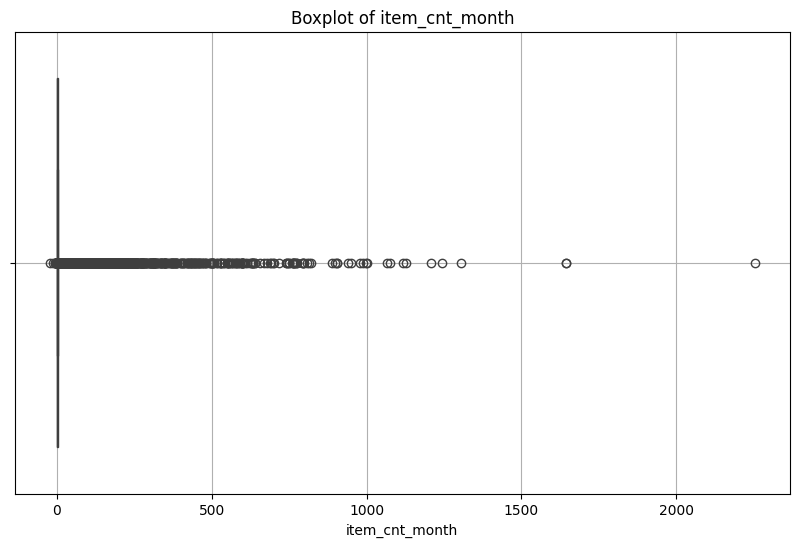

In [ ]:
#Check distribution of 'item_cnt_month
plt.figure(figsize=(10, 6))
sns.boxplot(x=train_df['item_cnt_month'])
plt.title('Boxplot of item_cnt_month')
plt.xlabel('item_cnt_month')
plt.grid(True)
plt.show()

In [81]:
train_df.item_cnt_month.describe()

count    1.609124e+06
mean     2.267200e+00
std      8.649882e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      2.253000e+03
Name: item_cnt_month, dtype: float64

In [ ]:
#Outlier removal for 'item_cnt_month
train_df = train_df[(train_df['item_cnt_month'] >= 0) & (train_df['item_cnt_month'] < 30)]

In [83]:
train_df['train'] = 1
test_df['train'] = 0

In [84]:
dataset = pd.concat([train_df,test_df], axis=0)

In [85]:
#Creating a lag variable
def lag_creating(df, lags, column):
    tmp = df[['date_block_num', 'shop_id', 'item_id', column]]
    for i in lags:
        shift = tmp.copy()
        shift.columns = ['date_block_num', 'shop_id', 'item_id', column + '_lag_' + str(i)]
        shift['date_block_num'] += i
        df = pd.merge(df, shift, on=['date_block_num', 'shop_id', 'item_id'], how='left')
    return df

In [86]:
dataset_lag = lag_creating(dataset,[1, 2, 3, 6, 12],'item_cnt_month')

In [108]:
train_df = dataset_lag[dataset_lag['train'] == 1].copy()
test_df = dataset_lag[dataset_lag['train'] == 0].copy()
train_df.drop(columns = 'train',inplace=True)
test_df.drop(columns = ["train","item_cnt_month"],inplace=True)

In [109]:
X = train_df.drop(columns='item_cnt_month')
y = train_df['item_cnt_month']
y = np.log1p(y)

In [ ]:
#Learning with crossvalidation
kf = KFold(n_splits=5,shuffle=True,random_state=10)
for train_index, test_index in kf.split(X):
	X_train, X_test = X.iloc[train_index], X.iloc[test_index]
	y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [111]:
lgb = LGBMRegressor()
model = lgb.fit(X_train, y_train)
#Since cross_val_score uses the "smaller is better" approach, it returns the MSE (mean squared error) as a negative value.
train_rmse=np.sqrt(-cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf))
test_rmse=np.sqrt(-cross_val_score(model, X_test, y_test,scoring='neg_mean_squared_error', cv=kf))

print('train rmse:',train_rmse.mean(),'test rmse:',test_rmse.mean())

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 575
[LightGBM] [Info] Number of data points in the train set: 1281362, number of used features: 9
[LightGBM] [Info] Start training from score 0.944750
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021793 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 576
[LightGBM] [Info] Number of data points in the train set: 1025089, number of used features: 9
[LightGBM] [Info] Start training from score 0.944888
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

In [112]:
#Display feature_importance
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lgb.feature_importances_
}).sort_values(by='importance', ascending=False)

print(importance_df.head(10))

                 feature  importance
3       item_category_id         671
0         date_block_num         535
2                item_id         367
4   item_cnt_month_lag_1         365
1                shop_id         352
5   item_cnt_month_lag_2         288
6   item_cnt_month_lag_3         194
7   item_cnt_month_lag_6         146
8  item_cnt_month_lag_12          82
